# Projet : Série Chronologique

### <i>Par Vahia Rabarijoana et Kévin Jousselin</i>

#### Master DataScience - Université d'Angers : <a href='https://math.univ-angers.fr/master-data-science/'>Master DS</a>

Nous avons choisis d'étudier le nombre de vidéos postées sur Youtube France entre XXX et XXX. Pour cela, nous avons récupérer l'ensemble des données disponibles à ce sujet sur <a href=https://www.kaggle.com/>Kaggle</a> : le fichier <u>'FR_youtube_trending_data.csv' (250 Mo)</u> issu du dataset <a href=https://www.kaggle.com/datasets/rsrishav/youtube-trending-video-dataset>'YouTube Trending Video Dataset (updated daily)'</a>.

Puis nous avons traité ces données afin de compter le nombre de publications par semaines (voir le Jupyter Notebook '<u>Extraction_donnees.ipynb</u>'). Nos données extraites ont été enregistrés dans le fichier <u>'data/export_nb_par_semaine.csv'</u>.

Nous allons maintenant tenter d'utiliser les méthodes ARIMA, SARIMA afin de modéliser le nombre de publications par semaine.

Voici le plan d'étude :
I - Extraction et observation des données
II - Recherche de différents modèles
III - Choix du "meilleur" modèle
IV - Prédiction avec le meilleur modèle

Importation des modules

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
#warnings.filterwarnings(action='ignore')   # Supprimer les avertissements liés aux tests Auto_Arima
#warnings.simplefilter("ignore")        # supprimer l'avertissement lié au test KPSS 'The actual p-value is greater than the p-value returned.'

# On importe quelques outils pour les SARIMA, ACF/PACF, tests usuels, ...
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss, adfuller

Importation des données

In [13]:
# dossier = '/users/2023/ds2/118003905/M2_serie_chrono/'
dossier = 'data/'
fichier = 'export_nb_par_semaine.csv'
#fichier = 'export_fr_par_jour.csv'

# On va travailler sur le jeu de données suivant :
Data = pd.read_csv(dossier+fichier)

# On enlève les premières dernières semaines qui représentent des semaines non entières.
Data = Data.iloc[2:-2]

# On renome les colonnes :
Data.columns = ['week', 'nb_vues']

# Séparons les dates, des valeurs :
Data_dates = Data['week']
Data_values = Data['nb_vues']

# 5 premières données :
print(Data.head(5))
n = len(Data_values)
print(n)

         week  nb_vues
2  2020-08-15     1395
3  2020-08-22     1428
4  2020-08-29      473
5  2020-09-01     1459
6  2020-09-08     1409
135


Testons immédiatement la stationnarité :

In [15]:
TestA = adfuller(Data_values) # Test ADF :    H0 Non Stationnaire
print("ADF p-val : ", TestA[1])
TestK = kpss(Data_values) # Test KPSS :       H0 Stationnaire
print("KPSS p-val : ", TestK[1])


ADF p-val :  2.283068542607219e-05
KPSS p-val :  0.1


Les tests semblent indiquer une stationnarité, mais cela reste douteux (p-value KPSS proche de 10%), observons les données :

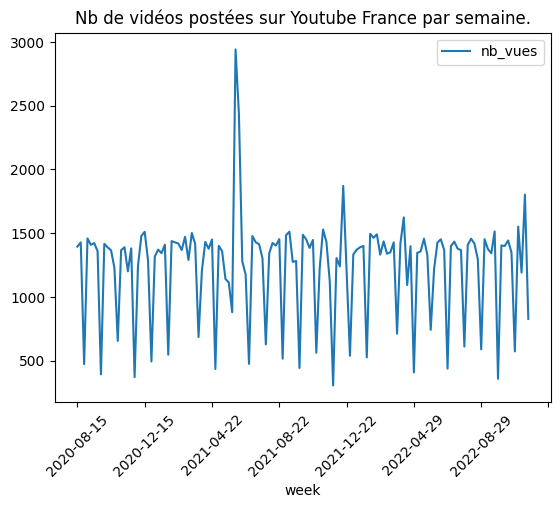

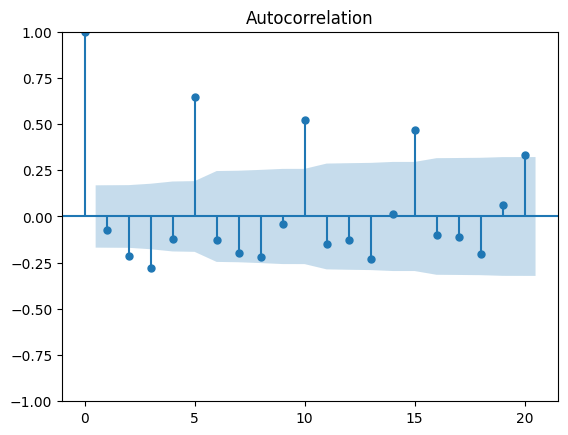

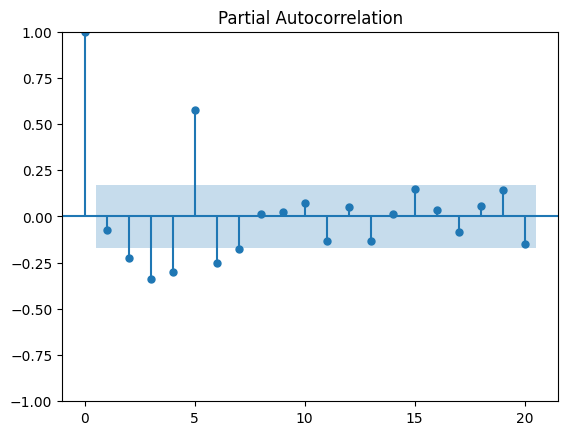

In [17]:
Data.plot(title = 'Nb de vidéos postées sur Youtube France par semaine.', x='week')
plt.xticks(rotation= 45)
plot_acf(Data_values, lags=20, alpha=0.05)
plot_pacf(Data_values, lags=20, alpha=0.05)
plt.show()

On observe clairement une périodicité de période 5, la série n'est pas stationnaire.

Appliquons une décomposition pour extraire les tendances linéaires et périodiques :

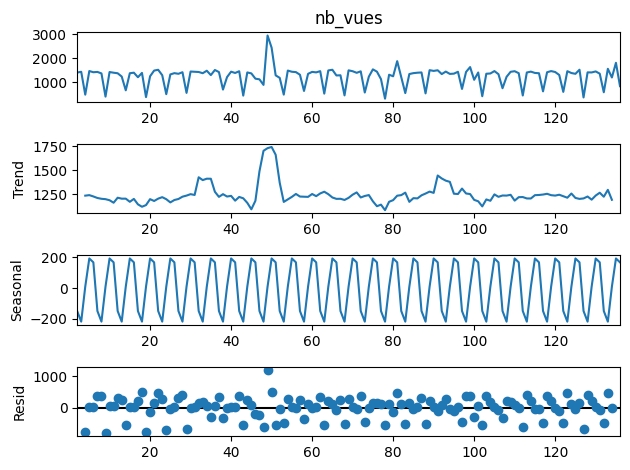

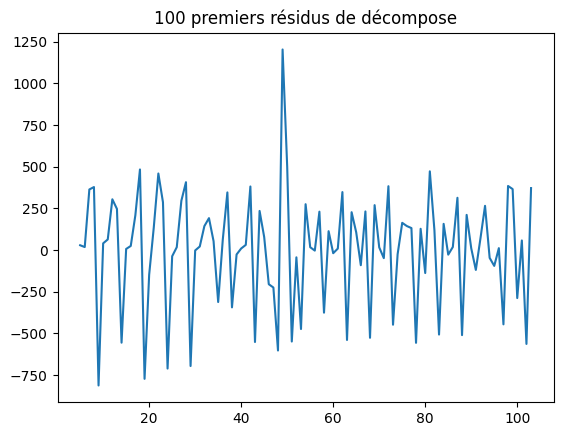

ADF p-val :  1.291442472591275e-07
KPSS p-val :  0.09680710797781689


In [18]:
# Décomposition 
Decomp = sm.tsa.seasonal_decompose(Data_values, model='additive', period = 5)
Decomp.plot()
plt.show()

# Regardons les rédidus
residus = Decomp.resid.dropna()
residus[1:100].plot()
plt.title('100 premiers résidus de décompose')
plt.show()

# Testons la stationnarité après désaisonnalisation (sur les résidus)
TestA = adfuller(residus)   # Test ADF :    H0 Non Stationnaire
print("ADF p-val : ", TestA[1])
TestK = kpss(residus)       # Test KPSS :   H0 Stationnaire
print("KPSS p-val : ", TestK[1])


Choississons une transformation de Box-Cox :

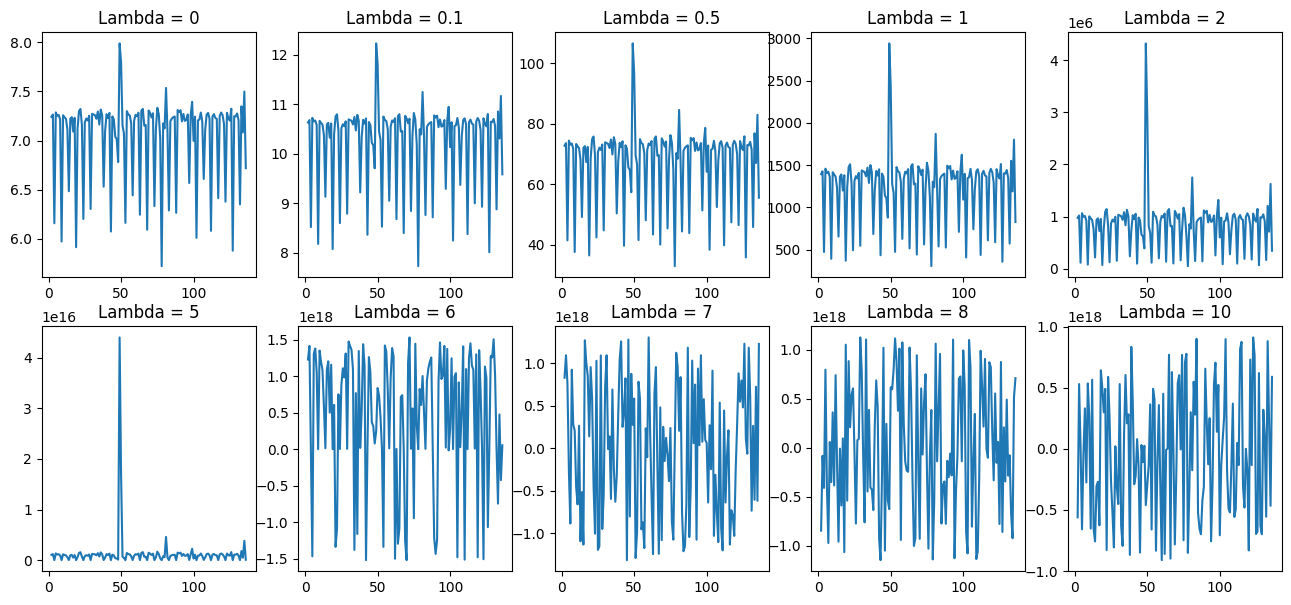

In [19]:
fig = plt.figure(figsize=(16,7))
axs = fig.subplots(2,5)

Liste_lambda = [0, 0.1, 0.5, 1, 2, 5, 6, 7, 8, 10]

for k, Lbda in enumerate(Liste_lambda):
    if Lbda == 0:                           # pour lambda = 0:   la transformation correspond à passer au log
        transf = np.log(Data_values)
    else: transf = (Data_values**Lbda-1)/Lbda
    transf.plot(ax = axs[k//5,k%5], title = f'Lambda = {Lbda}')

Les valeurs de Lambda entre 6 et 10 paraissent intéressantes, mais les valeurs sont proches de 10**18, trop proches des limites de précision de la machine. On choisit une transformation pour lambda = 0, c'est à dire qu'on applique le log :

In [20]:
Ldata = np.log(Data_values)
Ldata

2      7.240650
3      7.264030
4      6.159095
5      7.285507
6      7.250636
         ...   
132    6.350886
133    7.347300
134    7.082549
135    7.497207
136    6.719013
Name: nb_vues, Length: 135, dtype: float64

La PACF s'annulant pour h>=8, on peut essayer un modèle AR(7). Ce sera notre <span style='color:red'><b>modèle 1</b></span>.

### II - a) Modèles 2.X : élimination de la périodicité (pour la période 5)

On va éliminer la périodicité de 5 par une différentiation D=1, S=5, puis on vérifie la stationnarité :

ADF p-val :  1.4921886386810773e-12
KPSS p-val :  0.1


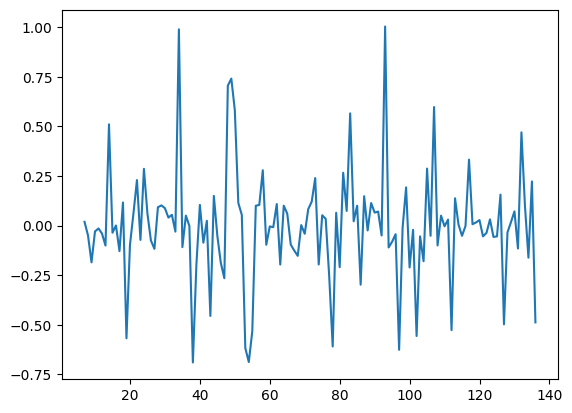

In [21]:
Ldata_Diff = Ldata.diff(5).dropna()
Ldata_Diff.plot()

# Testons la stationnarité après désaisonnalisation 
TestA = adfuller(Ldata_Diff) # Test ADF :    H0 Non Stationnaire
print("ADF p-val : ", TestA[1])
TestK = kpss(Ldata_Diff) # Test KPSS :       H0 Stationnaire
print("KPSS p-val : ", TestK[1])


Le test de stationnarité est douteux, on essaiera tout de même une série de modèles <span style='color:red'><b>(modèles 2.X)</b></span> : SARIMA(p,<span style='color:red'><b>0</b></span>,q)(P,<span style='color:red'><b>1</b></span>,Q)_<span style='color:red'><b>5</b></span> :

On lance manuellement plusieurs tests '<b>sm.tsa.statespace.SARIMAX(Ldata, order=(p, 0, q), seasonal_order=(P, 1, Q, 5), trend=None)</b>', 
pour différentes valeurs de $p\leq4 , q\leq4 , P\leq6$ et $Q\leq6$, et nous regardons la significativité des coefficients obtenus.

Voici un exemple de calculs effectués :

In [62]:
Mod = sm.tsa.statespace.SARIMAX(Ldata, order=(3, 0, 3), seasonal_order=(2, 1, 2, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False)  # Tendance constante inutile car dérivation
# trend = None : pas de tendance linéaire (Inutile car dérivation d'ordre 2)

ModF = Mod.fit()
print(ModF.summary())


                                       SARIMAX Results                                        
Dep. Variable:                                nb_vues   No. Observations:                  135
Model:             SARIMAX(3, 0, 3)x(2, 1, [1, 2], 5)   Log Likelihood                  -5.164
Date:                                Sat, 17 Dec 2022   AIC                             32.328
Time:                                        16:15:06   BIC                             62.617
Sample:                                             0   HQIC                            44.623
                                                - 135                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4263      0.294      1.450      0.147      -0.150       1.002
ar.

 ### II - b) Modèles 3.X : elimination de la périodicité et différentiation

Après avoir éliminer la périodicité (D=1), on va tenter une différentiation d=1, puis on vérifie la stationnarité :

ADF p-val :  3.3042140277776134e-07
KPSS p-val :  0.1


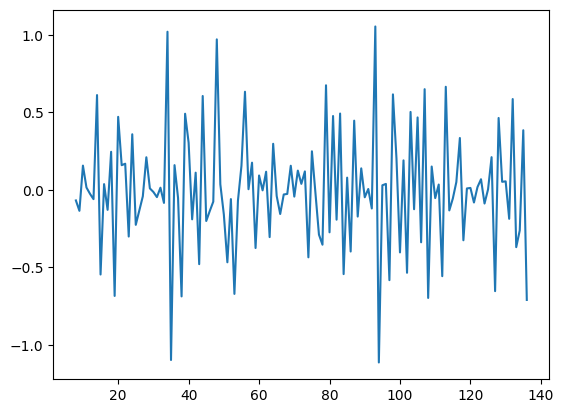

In [23]:
Ldata_dDiff = Ldata_Diff.diff(1).dropna()
Ldata_dDiff.plot()

# Testons la stationnarité après désaisonnalisation 
TestA = adfuller(Ldata_dDiff) # Test ADF :    H0 Non Stationnaire
print("ADF p-val : ", TestA[1])
TestK = kpss(Ldata_dDiff) # Test KPSS :       H0 Stationnaire
print("KPSS p-val : ", TestK[1])

Le test de stationnarité est douteux, on essaiera tout de même une série de modèles (modèles 3.X) : SARIMA(p,<span style='color:red'><b>1</b></span>,q)(P,<span style='color:red'><b>1</b></span>,Q)_<span style='color:red'><b>5</b></span>

### 
II - c) Modèles 4.X : Modèles proposé par AutoArima (package pmdarima.arima)

In [24]:
from pmdarima.arima import auto_arima

In [25]:
model = auto_arima(Ldata,
                      test='adf',   

                      # paramètres liés à la modélisation ARIMA : p, d, q
                      start_p=0, 
                      start_q=0,
                      max_p=8, max_q=8,
                      d=0,          
                      
                      seasonal=True,    # prendre en compte la saisonnalité
                      m=5,              # période de saisonnalité


                      # paramètres liés à la saisonnalité : P, D, Q
                      start_P=0, start_Q=0,
                      max_P=8, max_Q=8,
                      D=0, 
                      
                      max_order =10,                    # somme maximale des paramètres p, q, P, Q
                      n_jobs = 5,                       # Division du travail

                      information_criterion='bic',      # Critère de choix du 'meilleur modèle'

                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(0,0,0)(0,0,0)[5] intercept   : BIC=155.259, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : BIC=inf, Time=0.64 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : BIC=101.369, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[5]             : BIC=915.994, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[5] intercept   : BIC=148.993, Time=0.07 sec
 ARIMA(0,0,1)(1,0,1)[5] intercept   : BIC=inf, Time=0.96 sec
 ARIMA(0,0,1)(0,0,2)[5] intercept   : BIC=79.967, Time=0.28 sec
 ARIMA(0,0,1)(1,0,2)[5] intercept   : BIC=109.825, Time=1.00 sec
 ARIMA(0,0,1)(0,0,3)[5] intercept   : BIC=69.072, Time=0.62 sec
 ARIMA(0,0,1)(1,0,3)[5] intercept   : BIC=inf, Time=1.64 sec
 ARIMA(0,0,1)(0,0,4)[5] intercept   : BIC=66.736, Time=0.59 sec
 ARIMA(0,0,1)(1,0,4)[5] intercept   : BIC=inf, Time=2.35 sec
 ARIMA(0,0,1)(0,0,5)[5] intercept   : BIC=62.357, Time=1.10 sec
 ARIMA(0,0,1)(1,0,5)[5] intercept   : BIC=62.053, Time=3.06 sec
 ARIMA(0,0,1)(2,0,5)[5] intercept   : BIC=inf, Time=2.85 sec
 ARIMA(

La fonction <b>auto_arima</b> 'par défaut' nous propose des valeurs de différentiation d = D = 0, en contradiction avec nos observations.

Nous allons tester les modèles proposés, et relancer <b>auto_arima</b> en forçant les différentiations d = 1 ou D = 1,

Voici les différentes modélisations proposées obtenus avec les critères 'AIC' ou 'BIC' :


- Modèle 4.1 : BIC, d = D = 1 : <BLOCKQUOTE> ARIMA(2,1,0)(1,1,0)[5] 


- Modèle 4.2 : BIC d=0, D=1 :    <BLOCKQUOTE>ARIMA(0,0,0)(1,1,0)[5]


- Modèle 4.3 : BIC d=D=0   (cas renvoyé par les réglages par défaut) <BLOCKQUOTE>ARIMA(0,0,0)(0,0,5)[5]


- Modèle 4.4 : BIC d=1, D=0  <BLOCKQUOTE>ARIMA(1,1,0)(1,0,0)[5]


- AIC, D=1 ARIMA(0,0,0)(1,1,0)[5] : même modèle que 4.2




### Modèles 5.X : Une dernière classe de modèles peut être obtenue en lançant un Sarima(4,1,4)(4,1,4)_5 et en regardant la significativité des coefficients :

On a lancé manuellement plusieurs tests '<b>sm.tsa.statespace.SARIMAX(Ldata, order=(p, 1, q), seasonal_order=(P, 1, Q, 5), trend=None)</b>', 
pour différentes valeurs de $p\leq4 , q\leq4 , P\leq6 et Q\leq6$, et nous avons regarder la significativité des coefficients obtenus.

Voici un exemple de calculs effectués :

In [53]:
Mod = sm.tsa.statespace.SARIMAX(Ldata, order=(4, 1, 4), seasonal_order=(5, 1, 5, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False)  # Tendance constante inutile car dérivation
# trend = None : pas de tendance linéaire (Inutile car dérivation d'ordre 2)

ModF = Mod.fit()
print(ModF.summary())


                                            SARIMAX Results                                            
Dep. Variable:                                         nb_vues   No. Observations:                  135
Model:             SARIMAX(4, 1, 4)x(5, 1, [1, 2, 3, 4, 5], 5)   Log Likelihood                  -1.898
Date:                                         Sat, 17 Dec 2022   AIC                             41.795
Time:                                                 15:42:10   BIC                             91.102
Sample:                                                      0   HQIC                            61.745
                                                         - 135                                         
Covariance Type:                                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1     

On va retenir les modèles suivants :
- Modèle 5.1 : <BLOCKQUOTE> ARIMA(4,1,0)(5,1,0)[5] 
- Modèle 5.2 : <BLOCKQUOTE> ARIMA(0,1,0)(2,1,0)[5]
- Modèle 5.3 : <BLOCKQUOTE> ARIMA(3,1,0)(0,1,0)[5] 
- Modèle 5.4 : <BLOCKQUOTE> ARIMA(1,1,0)(1,1,1)[5] 
- Modèle 5.5 : <BLOCKQUOTE> ARIMA(3,0,4)(5,1,5)[5]    (pour d=0)

###  III - Choix du "meilleur" modèle
Nous allons départager nos différents modèles en fonction de leur capacités de prédictions.

Voici un rappel des 14 modèles SARIMA à tester :
<table border=0 cellpadding=0 cellspacing=0 width=432 >

 <tr height=19>
  <td height=19></td>
  <td>Modèles</td>
  <td>p</td>
  <td>d</td>
  <td>q</td>
  <td>P</td>
  <td>D</td>
  <td>Q</td>
  <td>S</td>
 </tr>
 <tr height=5>
  <td height=5></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
 </tr>
 <tr height=19>
  <td height=19>AR(7)</td>
  <td>1</td>
  <td>7</td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
 </tr>
 <tr height=5>
  <td height=5></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
 </tr>
 <tr height=19>
  <td height=19>d=0<span
  style='mso-spacerun:yes'>   </span>D=1</td>
  <td>2.1</td>
  <td>0</td>
  <td class=xl6727579>0</td>
  <td>0</td>
  <td>3</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>2.2</td>
  <td>3</td>
  <td class=xl6727579>0</td>
  <td>4</td>
  <td>5</td>
  <td class=xl6827579>1</td>
  <td>5</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>2.3</td>
  <td>2</td>
  <td class=xl6727579>0</td>
  <td>0</td>
  <td>3</td>
  <td class=xl6827579>1</td>
  <td>3</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>2.4</td>
  <td>3</td>
  <td class=xl6727579>0</td>
  <td>0</td>
  <td>1</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
 </tr>
 <tr height=5>
  <td height=5></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
 </tr>
 <tr height=19>
  <td height=19>d=1<span
  style='mso-spacerun:yes'>   </span>D=1</td>
  <td>3.1</td>
  <td>3</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>0</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>3.2</td>
  <td>4</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>3.3</td>
  <td>0</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>1</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>3.4</td>
  <td>0</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>2</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>3.5</td>
  <td>1</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>1</td>
  <td class=xl6827579>1</td>
  <td>1</td>
  <td>5</td>
 </tr>
 <tr height=5>
  <td height=5></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
  <td></td>
 </tr>
 <tr height=19>
  <td height=19>AutoArima</td>
  <td>4.1</td>
  <td>2</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>1</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>4.2</td>
  <td>0</td>
  <td class=xl6727579>0</td>
  <td>0</td>
  <td>1</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>4.3</td>
  <td>0</td>
  <td class=xl6727579>0</td>
  <td>0</td>
  <td>0</td>
  <td class=xl6727579>0</td>
  <td>5</td>
  <td>5</td>
 </tr>
 <tr height=19>
  <td height=19></td>
  <td>4.4</td>
  <td>1</td>
  <td class=xl6827579>1</td>
  <td>0</td>
  <td>1</td>
  <td class=xl6727579>0</td>
  <td>0</td>
  <td>5</td>
 </tr>

</table>


In [105]:
n_p_t = 3 # Nb de périodes tronquées
Ldata_tronque = Ldata[:-5*n_p_t]

In [134]:
liste_model = {}

# Un premier modèle :
liste_model['Mod11'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(7, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit()

# Modèles de type (d, D) = (0, 1)
liste_model['Mod21'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(0, 0, 0), seasonal_order=(3, 1, 3, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit()
liste_model['Mod22'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(3, 0, 4), seasonal_order=(5, 1, 5, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit()
liste_model['Mod23'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(2, 0, 0), seasonal_order=(3, 1, 3, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit()
liste_model['Mod24'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(3, 0, 0), seasonal_order=(1, 1, 1, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit()

# Modèles de type (d, D) = (1, 1)
liste_model['Mod31'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(3, 1, 0), seasonal_order=(0, 1, 0, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit()
liste_model['Mod32'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(4, 1, 0), seasonal_order=(5, 1, 0, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit()
liste_model['Mod33'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(0, 1, 0), seasonal_order=(1, 1, 0, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit()
liste_model['Mod34'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(0, 1, 0), seasonal_order=(2, 1, 0, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit()
liste_model['Mod35'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(1, 1, 0), seasonal_order=(1, 1, 1, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit()

# Autres modèles proposés par AutoArima
liste_model['Mod41'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(2, 1, 2), seasonal_order=(1, 1, 0, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit()
liste_model['Mod42'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(0, 0, 2), seasonal_order=(1, 1, 0, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit()
liste_model['Mod43'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(0, 0, 2), seasonal_order=(0, 0, 5, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit()
liste_model['Mod44'] = sm.tsa.statespace.SARIMAX(Ldata_tronque, order=(1, 1, 2), seasonal_order=(1, 0, 0, 5), trend=None, enforce_stationarity=False, enforce_invertibility=False).fit()


                                     SARIMAX Results                                     
Dep. Variable:                           nb_vues   No. Observations:                  120
Model:             SARIMAX(4, 1, 0)x(5, 1, 0, 5)   Log Likelihood                 -11.539
Date:                           Sat, 17 Dec 2022   AIC                             43.078
Time:                                   17:58:59   BIC                             67.504
Sample:                                        0   HQIC                            52.903
                                           - 120                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8112      0.105     -7.695      0.000      -1.018      -0.605
ar.L2         -0.7015      0.135     -5.200

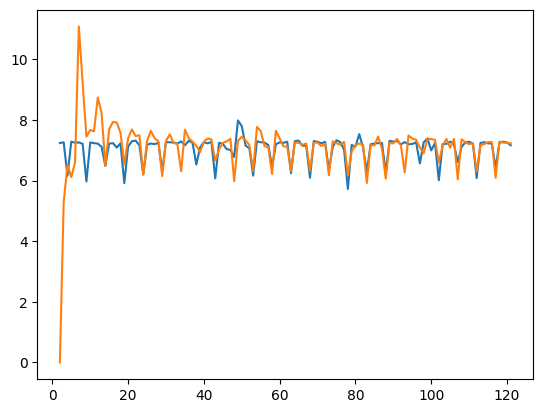

In [135]:
# Voici un résumé obtenu pour l'un des modèles
print(liste_model['Mod32'].summary())
Fig = Ldata_tronque.plot()
liste_model['Mod32'].fittedvalues.plot(ax = Fig)
Fig.figure
plt.show()

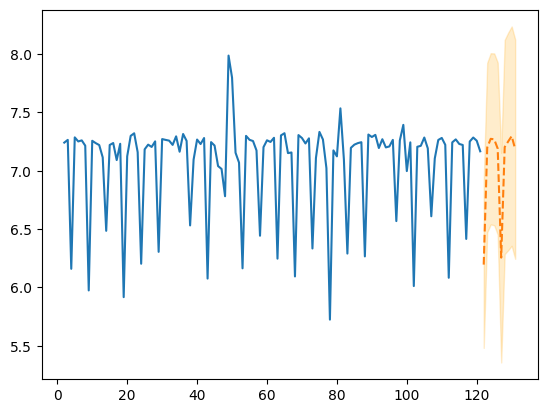

In [136]:
Pred = liste_model['Mod32'].get_forecast(steps=10).summary_frame(alpha=0.01)
Fig = Ldata_tronque.plot()
Pred['mean'].plot(ax=Fig, style='--')
Fig.fill_between(Pred.index, Pred['mean_ci_lower'], Pred['mean_ci_upper'], color='orange', alpha=0.2)
Fig.figure
plt.show()


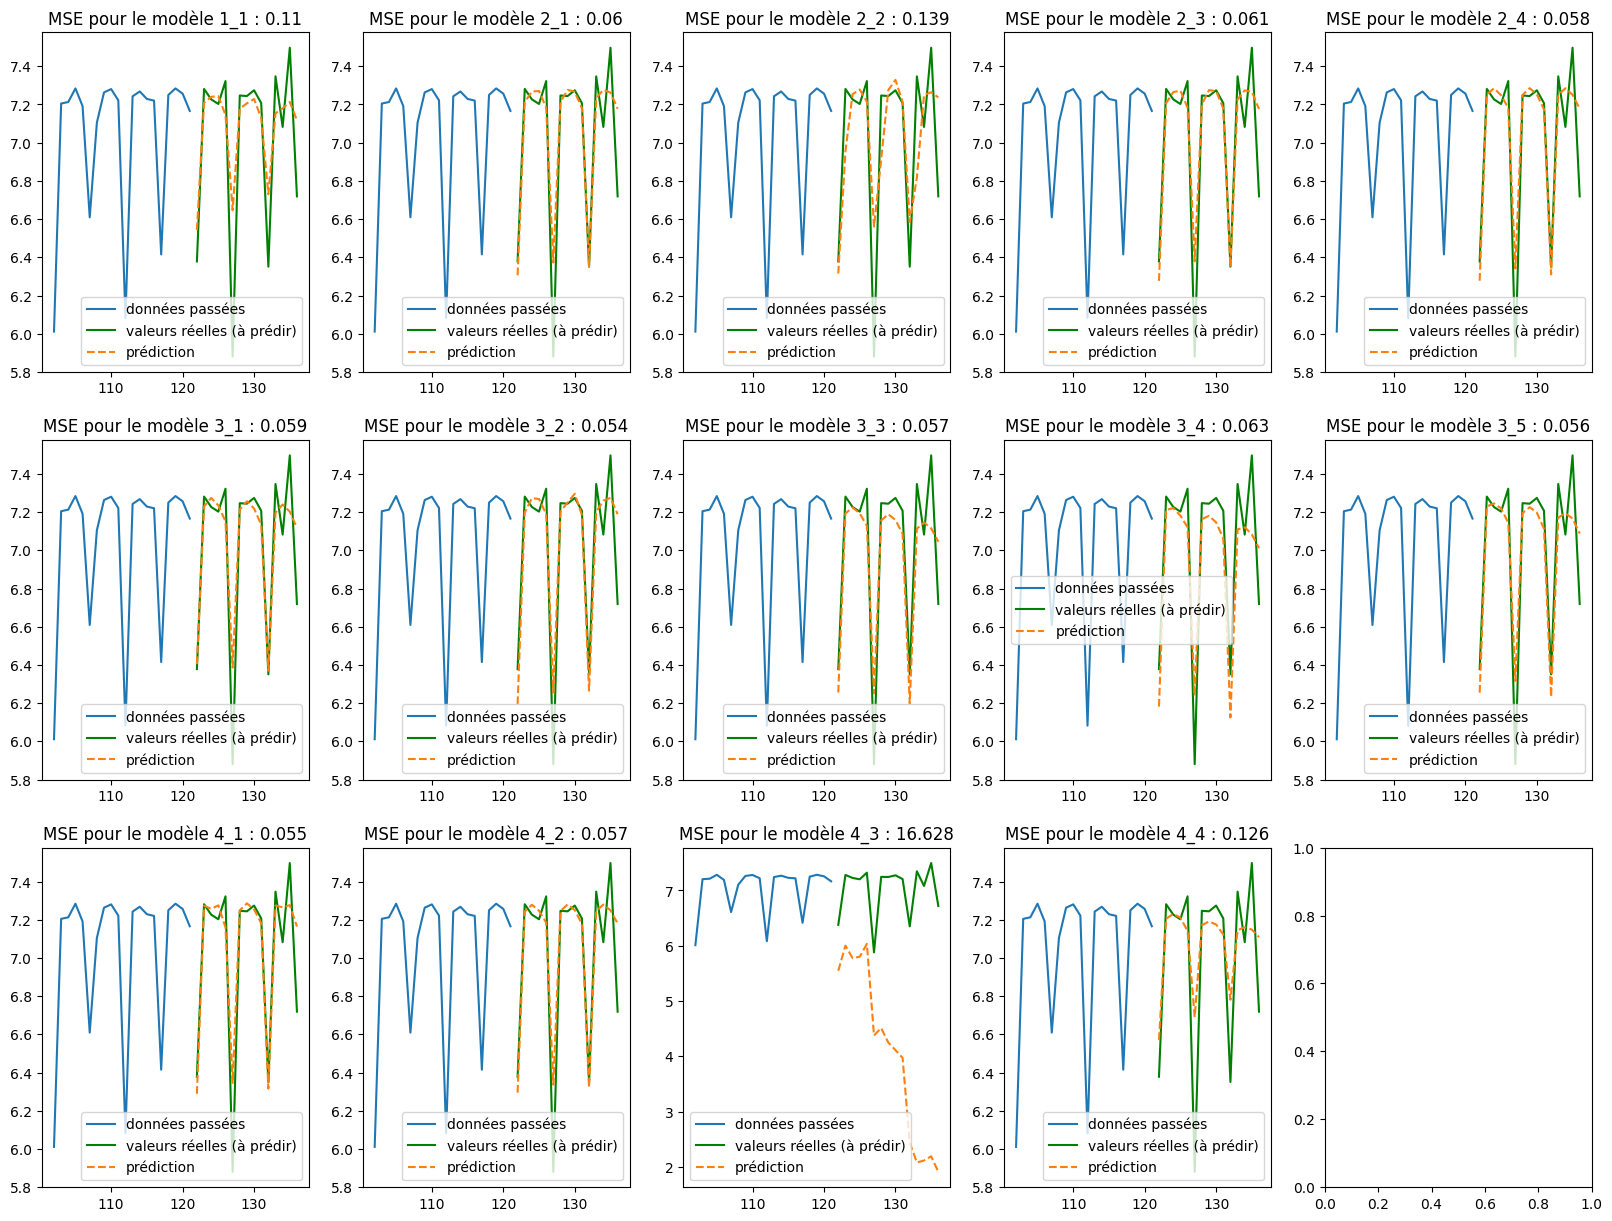

In [138]:
fig = plt.figure(figsize=(20,15))
axs = fig.subplots(3,5)

for k, mod in enumerate(liste_model):       # Parcours des 14 Modèles
    
    # Modèle concerné
    modele = liste_model[mod]

    # Fenêtre d'affichage
    fenetre = axs[k//5, k%5]

    # Prédiction à n_p_t périodes
    Pred = modele.get_forecast(steps=5*n_p_t).summary_frame(alpha=0.01)
    
    # MSE
    MSE = sum((Pred['mean']-Ldata[-5*n_p_t:])**2)/10  

    # Affichage des quelques valeurs précédentes
    Ldata_tronque[-20:].plot(ax=fenetre,  label='données passées')

    # Affichage des valeurs réelles en vert
    Ldata[-5*n_p_t:].plot(color='green', ax=fenetre,  label='valeurs réelles (à prédir)')

    # Affichage des prédictions en pointillé
    Pred['mean'].plot(ax=fenetre, style='--', label='prédiction')

    # Affichage du titre avec MSE arrondi au millième :
    fenetre.set_title(f'MSE pour le modèle {mod[3:4]}_{mod[4:]} : {round(MSE,3)}')
    fenetre.legend()    

plt.show()



On choisit BLABLA

Test sur les résidus, ...

### IV - Prédiction avec notre "meilleur" modèle